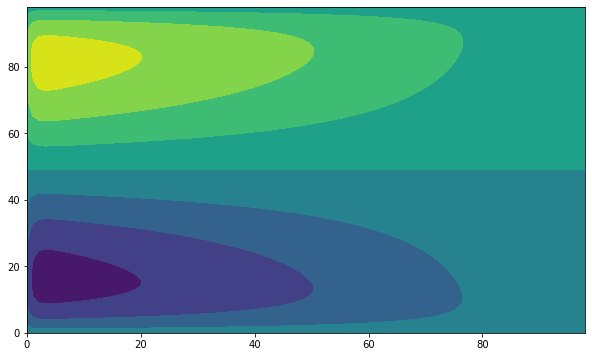

In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import animation
from tqdm import tqdm

# beta = 2e-11
# v = 500
# r = 1e-7
# dt = 30 min
# a = 2000 km

def laplacian2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([diag,-2*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')+sp.kron(mat,I)

def ddx2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')

def ddy2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(mat,I)

N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N-1)
y = np.linspace(dx,1-dx,N-1)
x, y = np.meshgrid(x,y)
pi = np.pi
dt = 1800
T = 1/dt
a = 2e6

lap = laplacian2D(N-1)/dx**2
ddx = ddx2D(N-1)/(2*dx)
ddy = ddy2D(N-1)/(2*dx)

r = 1e-7
beta = 2e-11

niter = 20000
nframes = 2000

for nu in [500]: #[0.5, 0.1, 0.05, 0.01, 0.001, 0.0001, -0.01, -0.1]:
    for taucoef in [1e-13]: #[np.pi, 1, 0.5, 0.1, -0.1, -0.5, -1, -np.pi]:

        #A = r * lap + beta * ddx
        B = - (nu/a**4) * lap.dot(lap) + (beta/a) * ddx #+ (r/a**2) * lap
        C = ((T + r)/a**2) * lap - (nu/a**4) * lap.dot(lap) + (beta/a) * ddx
        f = -taucoef * np.sin(pi*y)
        f_long = np.reshape(f,(N-1)**2)

        psi_long = spsolve(B,f_long)
        psi = np.reshape(psi_long,(N-1,N-1)) 

        psis = []

        for i in tqdm(range(niter)):
            q_long = lap.dot(psi_long)
            q_long_x = ddx.dot(q_long)
            q_long_y = ddy.dot(q_long)
            psi_long_x = ddx.dot(psi_long)
            psi_long_y = ddy.dot(psi_long)
            rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x)/(a**4) + (T * q_long)/(a**2)
            
            
            #psi_long = spsolve(A,rhs_long)
            psi_long = spsolve(C, rhs_long)

            if (i%(niter/nframes) == 0):
                psis.append(np.reshape(psi_long,(N-1,N-1)))
            #ax[i].contourf(x,y,psi)

        psimin = np.min(psis)
        psimax = np.max(psis)
        levels = np.linspace(psimin, psimax, 40)
        paras = dict(levels=levels, vmin=psimin, vmax=psimax, origin='lower')

        fig, ax = plt.subplots(figsize = (15, 10))
        c_ = ax.contourf(x, y, psis[0], **paras)
        cbar = plt.colorbar(c_)

        def animate(i):
            ax.clear()
            ax.contourf(x, y, psis[i], **paras)
            ax.set(title = f't = {round((niter/nframes)*i*dt/3600, 2)} hrs')

        ani = animation.FuncAnimation(fig, animate, nframes, interval=5, blit=False)
        plt.close()

        ani.save(f'anims/anim_nu_{nu}_taucoef_{round(taucoef, 2)}_{niter*dt/3600}hrs.mp4')
